In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow_text
import tensorflow_text

     |████████████████████████████████| 4.9 MB 3.9 MB/s 


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/dirve')

Mounted at /content/dirve


Import the dataset

In [ ]:
import pandas as pd
df = pd.read_csv('/content/dirve/MyDrive/Data/spam.csv',encoding='latin-1')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.head(5)


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.groupby('Category').describe()

Message                                                               
           count unique                                                top freq
Category                                                                       
ham         4825   4516                             Sorry, I'll call later   30
spam         747    653  Please call our customer service representativ...    4

To Check The Percentage Distribution Between Ham and Spam Email

In [ ]:
df['Category'].value_counts()


ham     4825
spam     747
Name: Category, dtype: int64

In [ ]:
747/4825

0.15481865284974095

Here We Can See 15% are Spam Email and 85% are Ham Email. This is clearly a data embalance. For example, fraud detection is a common problem that we try to solve in the field of machine learning but when we are training your model with a training set for fraud transaction we will often find that we will have 10000 good transaction and only one will be fraud this creates an imbalance in our data set and even if we write a simple python prediction function which returns false all the time even with that stupid function we can get 99 percent accuracy because majority of the transactions are not fraud but on the other hand what we care about is the forefront injection so although accuracy is 99 percent the function is still performing horribly because it's not telling you what is fraud so this kind of imbalance creates a lot of issues in the field of machine learning and there are some ways to tackle that one of the way is oversampling.

### Creating new DataFrame for Ham and Spam Email for downsampling Data Balance Approach. Because 15% spam emails, 85% ham emails: This indicates class imbalance.

In [ ]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [ ]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [ ]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

To create DF balance Dataframe I concatenate two dataframe

In [ ]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

Now there is equal number of Spam and Ham Email. I picked only 747 ham email and discarded all category.

In [ ]:
df_balanced['Category'].value_counts()


spam    747
ham     747
Name: Category, dtype: int64

If we want to print some sample then

In [ ]:
df_balanced.sample(5)

,Category,Message
2412,spam,I don't know u and u don't know me. Send CHAT ...
3422,spam,Had your mobile 10 mths? Update to latest Oran...
1680,ham,Okay... We wait ah
1968,ham,2 laptop... I noe infra but too slow lar... I ...
366,spam,"Update_Now - Xmas Offer! Latest Motorola, Sony..."


Now, I would create a new column called spam cause in the previous data frame was a text column I want to create a Binary coloumn. Like Boolean 1 or 0 that type of things.

In [ ]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(10)

,Category,Message,spam
5523,ham,Going to join tomorrow.,0
3481,spam,Do you want a NEW video phone750 anytime any n...,1
3232,ham,Height of recycling: Read twice- People spend ...,0
3466,spam,URGENT! We are trying to contact U. Todays dra...,1
1049,spam,18 days to Euro2004 kickoff! U will be kept in...,1
4154,spam,Want a new Video Phone? 750 anytime any networ...,1
3836,ham,Early bird! Any purchases yet?,0
1140,ham,Oh:)as usual vijay film or its different?,0
3489,ham,Huh but i got lesson at 4 lei n i was thinkin ...,0
906,spam,"all the lastest from Stereophonics, Marley, Di...",1


### Now I have my DataFrame Ready and I am ready to do train test split. Split it into training and test data set. Here we use startify so that in our train nad test sample the distribution of the category is equal.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'],stratify=df_balanced['spam'])

In [ ]:
X_train.head(4)


2479    Sppok up ur mob with a Halloween collection of...
2133    Spoke with uncle john today. He strongly feels...
4819    Check Out Choose Your Babe Videos @ sms.shsex....
1411    somewhere out there beneath the pale moon ligh...
Name: Message, dtype: object

Now lets import BERT model and get embeding vectors for few sample statements

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

By using a function here we are giving sentences on input and getting preprocessed text an output. And that we supply in the bert encoder.The encoder will return a dictionary. And from that dictionary we need to choose pooled output.

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.5132727 , -0.88845736, ..., -0.74748856,
        -0.7531474 ,  0.91964495],
       [-0.8720837 , -0.5054399 , -0.94446677, ..., -0.8584751 ,
        -0.71745366,  0.88082993]], dtype=float32)>

### Get embeding vectors for few sample words. Compare them using cosine similarity. Here cosine similarity is a measure how similar to vectors are. If two vectors are pointing in the same direction then that means the cosine similarity will be close to 1. if we have vectors where the angle is less the they are more similar and if we have vectors the angle is more then they are less similar.

In [ ]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

We have six embeddings. Each embeddings have 768 vectors. Here above first three term similar (fruits) in terms of cosine similarity. Then, the last three terms also similar (name of persons) in terms of cosine similarity.

In [ ]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.7606917 , -0.14219375,  0.49604657, ...,  0.4216535 ,
        -0.5322139 ,  0.80312175],
       [-0.86023194, -0.21242912,  0.49157023, ...,  0.39798135,
        -0.6050627 ,  0.8447164 ],
       [-0.7128861 , -0.154639  ,  0.38401696, ...,  0.35278732,
        -0.5099133 ,  0.734741  ],
       [-0.8253345 , -0.3555056 , -0.59069616, ..., -0.01613677,
        -0.6141757 ,  0.8723029 ],
       [-0.7504135 , -0.2681262 , -0.266897  , ...,  0.02839394,
        -0.5938099 ,  0.7974987 ],
       [-0.78544354, -0.29949662,  0.41027504, ...,  0.5222545 ,
        -0.49573535,  0.8150749 ]], dtype=float32)>

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911089]], dtype=float32)

### Values near to 1 means they are similar. 0 means they are very different. Above I can use comparing "banana" vs "grapes" I get 0.99 similarity as they both are fruits.

In [ ]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703845]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes.

In [ ]:
cosine_similarity([e[3]],[e[4]])

array([[0.98720354]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

We need to understand how the embeddings are calculated. They are calculated based on the training they did on wekipidia and google books where based on the context.

Here, I am using the preprocessing and encoding this two functions into BERT layer. Here I am creating model. There are two process to crate tensorflow model. One is sequential and one is functional. Here I used sequential model. First I will create a input layer and passed I will pass it to BERT preprocess. And that I supplied it to BERT encoder. And we get output as a result. Now, I will create Neural Networks Layer. I created dropout layers because 

Sigmoid activation function, sigmoid(x) = 1 / (1 + exp(-x)).

Applies the sigmoid activation function. For small values (<-5), sigmoid returns a value close to zero, and for large values (>5) the result of the function gets close to 1.

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

Here, we can see that trainable parameter is 769 because 1 is dense layer and dropout layer 768. And others are non trainable parameter nad these are coming from BERT. We don't worry about retraining them. The actual training is driven by loss function. Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. 

 The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters.0

### Train the model

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=10)


Epoch 1/10
35/35 [==============================] - 449s 13s/step - loss: 0.6090 - accuracy: 0.6821 - precision: 0.6962 - recall: 0.6464
Epoch 2/10
35/35 [==============================] - 438s 13s/step - loss: 0.4842 - accuracy: 0.8313 - precision: 0.8204 - recall: 0.8482
Epoch 3/10
35/35 [==============================] - 435s 12s/step - loss: 0.4298 - accuracy: 0.8429 - precision: 0.8357 - recall: 0.8536
Epoch 4/10
35/35 [==============================] - 437s 12s/step - loss: 0.3830 - accuracy: 0.8777 - precision: 0.8591 - recall: 0.9036
Epoch 5/10
35/35 [==============================] - 437s 12s/step - loss: 0.3532 - accuracy: 0.8866 - precision: 0.8739 - recall: 0.9036
Epoch 6/10
35/35 [==============================] - 437s 12s/step - loss: 0.3352 - accuracy: 0.8884 - precision: 0.8680 - recall: 0.9161
Epoch 7/10
35/35 [==============================] - 436s 12s/step - loss: 0.3194 - accuracy: 0.8893 - precision: 0.8879 - recall: 0.8911
Epoch 8/10
35/35 [=======================

If we are training on imbalance dataset we should not relay on accuracy. When we do model evaluation. When we do model.predict. We get y predicted and it is two dimensional but flatten make it one dimensional.

In [ ]:
model.evaluate(X_test, y_test)


12/12 [==============================] - 147s 12s/step - loss: 0.2272 - accuracy: 0.9492 - precision: 0.9286 - recall: 0.9733


[0.22723731398582458,
 0.9491978883743286,
 0.9285714030265808,
 0.9732620120048523]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted


array([1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 


array([[173,  14],
       [  5, 182]])

Text(33.0, 0.5, 'Truth')

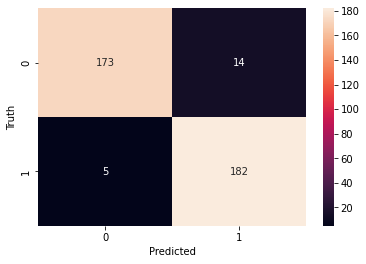

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.97      0.93      0.95       187
           1       0.93      0.97      0.95       187

    accuracy                           0.95       374
   macro avg       0.95      0.95      0.95       374
weighted avg       0.95      0.95      0.95       374



**Inference**

In [ ]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.772009  ],
       [0.82894   ],
       [0.7606824 ],
       [0.18863174],
       [0.08314577]], dtype=float32)